# South Africa

S5P NO2: Original resolution: 7km x 7km. Improved resolution: 1km x 1km.

Predictors used at the moment:
* DEM

In [1]:
# Built-in modules
import os
import gzip
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import glob
import re
import warnings
from collections import defaultdict

# Basics of Python data handling and visualization
import fs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from shapely import wkt
import rasterio as rio
from shapely import geometry
from rasterstats import zonal_stats
import seaborn as sns

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate, GroupKFold
import statistics 

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType, AddFeature, MapFeatureTask, MergeFeatureTask, RemoveFeature,LoadTask, SaveTask, OverwritePermission
from sentinelhub import bbox_to_dimensions, bbox_to_resolution
from eolearn.io import ExportToTiff

# Visualisation utils
from utils import (get_extent, 
                   draw_outline, 
                   draw_bbox, 
                   draw_feature, 
                   draw_true_color,
                   unzip_file,
                   load_tiffs,
                   load_list_tiffs,
                   days_to_datetimes,
                   datetimes_to_days,
                   reproject_tiff,
                   upscale_tiff,
                   mask_tiff)# South Africa

from utils_carles import polygrid, export_geotiff, percs_landuse, upscale_mean_tiff, extract_points_from_raster

In [2]:
DATA_DIR = Path('training_dataset_south_africa')
AOIS = ['South_Africa']

In [3]:
OFFSET = 2100
NO_DATA_VALUE = -9999.0

In [4]:
# CHANGE THIS VALUE to True IF PRE-PROCESSING NEEDS TO BE DONE
preproc = True

## Model Validation

Create target grid for the AOI (1 km)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # This is added back by InteractiveShellApp.init_path()


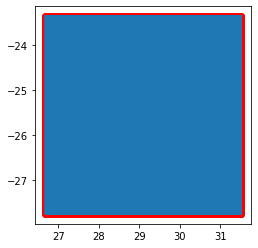

In [6]:
# Prepare grid
bounds_down = list(s5p_eop.bbox)
res_down = bbox_to_dimensions(s5p_eop.bbox, 1000)

x_res_down = (bounds_down[2]-bounds_down[0])/res_down[0]
y_res_down = (bounds_down[3]-bounds_down[1])/res_down[1]

bounds_down = geometry.box(bounds_down[0], bounds_down[1], bounds_down[2], bounds_down[3])
bounds_down = gpd.GeoDataFrame({"id":1,"geometry":[bounds_down]}, crs="EPSG:4326")
s5p_grid_down = polygrid(bounds_down, x_res_down,y_res_down, 4326)
s5p_centroids_down = gpd.GeoDataFrame(geometry= s5p_grid_down.centroid)

#del s5p_eop

# Show it
p = s5p_grid_down.boundary.plot()
s5p_centroids_down.plot(ax=p, color='red')
plt.show()


### Extract predictor data at target grid for the AOI (1 km)

#### Prepare DEM with 1km NO2

In [75]:
no_data_value = 128
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_val_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                            filename='NO2_DEM_1km.tif',
                           no_data_value=no_data_value)

## FILTER NO VALID DATA BEFORE STARTING
dem_val_eop.data_timeless['DEM'][dem_val_eop.data_timeless['DEM'] == no_data_value] = np.nan

# Perform zonal statistics - mean altitude per CAMS pixel
src = rio.open(str(dem_train_dir) + '/NO2_DEM_1km.tif')
affine = src.transform
array = dem_train_eop.data_timeless['DEM']
array = array[:, :, 0]
dem_grid_val = s5p_grid_down
zstats = zonal_stats(dem_grid_val, array, affine=affine, stats="mean", nodata=np.nan)
vals = []
for index, value in enumerate(zstats):
    vals.append(value['mean'])
    
dem_grid_val['elevation'] = vals

In [106]:
# Now we can rasterize
minx, miny, maxx, maxy = s5p_grid_down.geometry.total_bounds
sizey = round((maxy-miny)/y_res_down)
sizex = round((maxx-minx)/x_res_down)
transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
shapes = ((geom, value) for geom, value in zip(dem_grid_val.geometry, dem_grid_val['elevation']))

dem_val = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)

export_geotiff(str(dem_train_dir) + '/DEM_NO2_Val.tif', dem_val, transform, 4326)

#### Prepare ERA5 with 1km NO2

In [7]:
## Paths of validation ERA5 
VAL_DATA_DIR = Path("validation_dataset_south_africa")
era5_val_dir = VAL_DATA_DIR/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_val_dir))


In [ ]:
## Create direction for resampled ERA5 match 1 km NO2 gird

resampled_val_era5_location = str(VAL_DATA_DIR/AOIS[0])+'/resampled_val_era5_no2'
if not os.path.isdir(resampled_val_era5_location):
    os.makedirs(resampled_val_era5_location)
    for i in era5_products:
        os.mkdir(resampled_val_era5_location + '/' + i)  

## Upscale the validation ERA5

target_size = bbox_to_dimensions(s5p_eop.bbox, 1000)
for i in era5_products:
    for j in glob.glob(str(era5_val_dir) + '/' + i + '/*.tif'):
        path_in = j
        path_out = re.sub('era5', 'resampled_val_era5_no2', path_in)
        upscale_tiff(path_in, path_out, target_size)


In [11]:
## Select ERA5 data with the same dates of submission
resampled_val_era5_location = str(VAL_DATA_DIR/AOIS[0])+'/resampled_val_era5_no2'

days = [2150,2153,2161,2170,2178,2180,2186,2190,2196,2200]
hours = ['h10','h11','h11','h10','h11','h10','h10','h11','h10','h11']
files_name = []
for era5_p in era5_products:
    era5_product_paths = []
    for i,day in enumerate(days):
            era5_product_path = glob.glob(str(resampled_val_era5_location) +'/' +era5_p + '/' +  f'*day{day}_{hours[i]}.tif')[0:2208]
            era5_product_paths = era5_product_paths + era5_product_path
    
    filenames = [path.replace(str(resampled_val_era5_location) + f'/{era5_p}/','') for path in era5_product_paths]
 
        
    files_name.append(filenames)

#files_name


In [12]:
## Load Selected ERA5

# Load data
val_era5_eops = []
for file_names, era5_p in [(files_name[0], 'relative_humidity'),(files_name[1], 'specific_rain_water_content'),(files_name[2], 'wind_u'),(files_name[3], 'wind_v')]:
    val_era5_eop = load_list_tiffs(Path(resampled_val_era5_location)/era5_p, 
                               (FeatureType.DATA,era5_p), 
                                offset=OFFSET,
                                filename = file_names,
                                image_dtype=np.float32,
                                data_source='era5')
    val_era5_eops.append(val_era5_eop)



# Merge into one EOPS
val_era5_eop = EOPatch(data={'relative_humidity': val_era5_eops[0].data['relative_humidity'], 
                         'specific_rain_water_content': val_era5_eops[1].data['specific_rain_water_content'],
                        'wind_u': val_era5_eops[2].data['wind_u'],
                        'wind_v': val_era5_eops[3].data['wind_v']},
                   meta_info={'Names_relative_humidity': val_era5_eops[0].meta_info['Names'],
                              'Names_specific_rain_water_content': val_era5_eops[1].meta_info['Names'],
                             'Names_wind_u': val_era5_eops[2].meta_info['Names'],
                             'Names_wind_v': val_era5_eops[3].meta_info['Names']},
                     timestamp=val_era5_eops[0].timestamp,
                     bbox=val_era5_eops[0].bbox)
del val_era5_eops
#val_era5_eop

In [13]:
## Filter NO VALID DATA OF ERA5
NO_DATA_VALUE = -32767

val_era5_eop.data['relative_humidity'][val_era5_eop.data['relative_humidity'] == NO_DATA_VALUE] = np.nan
val_era5_eop.data['specific_rain_water_content'][val_era5_eop.data['specific_rain_water_content'] == NO_DATA_VALUE] = np.nan
val_era5_eop.data['wind_u'][val_era5_eop.data['wind_u'] == NO_DATA_VALUE] = np.nan
val_era5_eop.data['wind_v'][val_era5_eop.data['wind_v'] == NO_DATA_VALUE] = np.nan

In [ ]:
# Perform zonal statistics - ERA5 products per NO2 pixel

## location of exported tiff (ERA5 matching 1km NO2 grid)
val_rastrize_era5_location = str(VAL_DATA_DIR/AOIS[0])+'/val_rastrize_era5_no2'
if not os.path.isdir(val_rastrize_era5_location):
    os.makedirs(val_rastrize_era5_location)
    for i in era5_products:
        os.mkdir(val_rastrize_era5_location + '/' + i)
        
for index, era5p in enumerate(era5_products):
    tiffs = sorted(files_name[index])
    i=0
    for tiff in tiffs:
        for era5_path in glob.glob(str(resampled_val_era5_location) + '/' + era5p + '/' +  tiff):
            src = rio.open(era5_path)
            affine = src.transform
            array = val_era5_eop.data[era5p][i]
            array = array[:, :, 0]
            era5_grid = s5p_grid_down
            era5_stats = zonal_stats(era5_grid, array, affine=affine, stats="mean", nodata=np.nan)
            print("I am here")

            vals = []
            for index, value in enumerate(era5_stats):
                vals.append(value['mean'])

            era5_grid[era5p] = vals

            # rasterize
            minx, miny, maxx, maxy = s5p_grid_down.geometry.total_bounds
            sizey = round((maxy-miny)/y_res_down)
            sizex = round((maxx-minx)/x_res_down)

            transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
            shapes = ((geom, value) for geom, value in zip(era5_grid.geometry, era5_grid[era5p]))
            era5 = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
            tiffname = val_era5_eop.meta_info['Names_'+ era5p][i]
            export_geotiff(str(val_rastrize_era5_location) + '/' +era5p + '/'+ tiffname, era5, transform, 4326)
            #print(Done)
            i+=1

#del val_era5_eop

## Prediction

In [18]:
bbox_sa = gpd.read_file('AOIs_bboxes/South_Africa/South_Africa_test.shp')

In [19]:
cams_pm25_test_dir = Path('validation_dataset_south_africa/South_Africa/sentinel5P/NO2')
dates_sa_no2 = pd.read_csv('submission_date/SA-date-NO2.txt')
dates_sa_no2

Day  time
0  2150   h10
1  2153   h11
2  2161   h11
3  2170   h10
4  2178   h11
5  2180   h10
6  2186   h10
7  2190   h11
8  2196   h10
9  2200   h11

In [20]:
## Prepare the test images
input_filenames = []
for index in dates_sa_no2.index:
    day, time = dates_sa_no2.iloc[index]
    input_filename = f'S5P_NO2__OFFL_L2_day{day}_T{time.split("h")[-1]}.tif'
    input_filenames.append(input_filename)

input_filenames

['S5P_NO2__OFFL_L2_day2150_T10.tif',
 'S5P_NO2__OFFL_L2_day2153_T11.tif',
 'S5P_NO2__OFFL_L2_day2161_T11.tif',
 'S5P_NO2__OFFL_L2_day2170_T10.tif',
 'S5P_NO2__OFFL_L2_day2178_T11.tif',
 'S5P_NO2__OFFL_L2_day2180_T10.tif',
 'S5P_NO2__OFFL_L2_day2186_T10.tif',
 'S5P_NO2__OFFL_L2_day2190_T11.tif',
 'S5P_NO2__OFFL_L2_day2196_T10.tif',
 'S5P_NO2__OFFL_L2_day2200_T11.tif']

#### Extract DEM


In [21]:
# Extract DEM
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
raster_path = [(str(dem_train_dir) + '/DEM_NO2_Val.tif')]
dem_val_df = extract_points_from_raster(s5p_centroids_down, raster_path, 'DEM')
dem_val_df = pd.concat(dem_val_df)
dem_val_df = dem_val_df.dropna()
dem_val_df = dem_val_df.drop('raster', 1)  

In [22]:
dem_val_df

lon        lat          DEM
0      26.682232 -23.361811  1001.574829
1      26.682232 -23.370981   977.360474
2      26.682232 -23.380151   954.151428
3      26.682232 -23.389321   969.581787
4      26.682232 -23.398491   989.022034
...          ...        ...          ...
30787  27.309505 -23.976201   790.465149
30788  27.309505 -23.985371   774.197266
30789  27.309505 -23.994541   636.179626
30790  27.309505 -24.003711   678.383911
30791  27.309505 -24.012881   827.870117

[3894 rows x 3 columns]

In [23]:
## Create submission file

submission_dir = Path('test-submission')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(submission_dir/aoi/product):
            os.makedirs(submission_dir/aoi/product)
            
visulize_dir = Path('test-visulize')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(visulize_dir/aoi/product):
            os.makedirs(visulize_dir/aoi/product)

In [29]:
# Extract val ERA5

## We can put this function in the utility file
def extract_val_era5(era5_p,tiff_name,no2_centroids,path):
    era5_path = [(str(path) + '/'+ era5_p + '/' +tiff_name + '.tif')]
    era5_df = extract_points_from_raster(no2_centroids, era5_path, era5_p)
    era5_df = pd.concat(era5_df)
    era5_df = era5_df.dropna()
    return era5_df



#### Predict UPSCALED NO2 VALUES 

In [ ]:
## Direction in case not doing the previous steps
VAL_DATA_DIR = Path("validation_dataset_south_africa")
val_rastrize_era5_location = str(VAL_DATA_DIR/AOIS[0])+'/val_rastrize_era5_no2'

bbox_sa.to_crs(epsg=4326, inplace=True)
bbox_sa.to_file('AOIs_bboxes/WGS84/sa-bbox-wgs84.shp', driver='ESRI Shapefile')

test_df = dem_val_df

for input_filename in input_filenames:
    test_df['date']=np.nan
    test_df['hour']=np.nan
    test_df['datehour']=""
    
    for i in range(test_df.shape[0]):
        tiff_name = input_filename
        day, hour = tiff_name.split('_day')[-1].split('_')
        test_df.iat[i,test_df.columns.get_loc('date')] = day
        test_df.iat[i,test_df.columns.get_loc('hour')] = hour[1:3]
        test_df.iat[i,test_df.columns.get_loc('datehour')] = str(day)+str(hour[1:3])
        
    ##Extract ERA5 data for the same date and hour    
    test_rh_df = extract_val_era5('relative_humidity', f'ERA5_rh_day{day}_h{hour[1:3]}', s5p_centroids_down, val_rastrize_era5_location)
    test_srwc_df = extract_val_era5('specific_rain_water_content', f'ERA5_srwc_day{day}_h{hour[1:3]}' ,s5p_centroids_down, val_rastrize_era5_location)
    test_u_df = extract_val_era5('wind_u', f'ERA5_u_day{day}_h{hour[1:3]}', s5p_centroids_down, val_rastrize_era5_location)
    test_v_df = extract_val_era5('wind_v', f'ERA5_v_day{day}_h{hour[1:3]}' ,s5p_centroids_down, val_rastrize_era5_location)
    
    
    ## Join ERA5 & DEM data with (location)
    test_X = pd.merge(test_df, test_rh_df, on=['lon', 'lat'], how='inner')
    test_X = pd.merge(test_X, test_srwc_df, on=['lon', 'lat'], how='inner')
    test_X = pd.merge(test_X, test_u_df, on=['lon', 'lat'], how='inner')
    test_X = pd.merge(test_X, test_v_df, on=['lon', 'lat'], how='inner')
    

    # X inputs
    test_X = np.array(test_X.drop(['date','datehour','raster_x','raster_y'], axis=1))
    
    ## PREDICTION
    predicted_NO2 = rf.predict(test_X)
    
    
    ## rastrize
    minx, miny, maxx, maxy = s5p_grid_down.geometry.total_bounds
    sizey = round((maxy-miny)/y_res_down)
    sizex = round((maxx-minx)/x_res_down)
    transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
    shapes = ((geom, value) for geom, value in zip(s5p_grid_down.geometry, predicted_NO2))
    upscaled_NO2 = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
    
    ## export for prediction
    export_geotiff(str(submission_dir) + '/South_Africa/PM2.5/'+f'{day}_PM25_South_Africa.tif', upscaled_NO2, transform, 4326)
    
    mask_tiff('AOIs_bboxes/WGS84/sa-bbox-wgs84.shp', 
              submission_dir/'South_Africa'/'PM2.5'/f'{day}_PM25_South_Africa.tif', 
              submission_dir/'South_Africa'/'PM2.5'/f'{day}_PM25_South_Africa.tif')
    
    ## export them for visualization 
    export_geotiff(str(visulize_dir) + '/South_Africa/PM2.5/'+f'CAMS_PM25_day{day}_{hour}.tif', upscaled_NO2, transform, 4326)
    
    mask_tiff('AOIs_bboxes/WGS84/sa-bbox-wgs84.shp', 
              visulize_dir/'South_Africa'/'PM2.5'/f'CAMS_PM25_day{day}_{hour}.tif', 
              visulize_dir/'South_Africa'/'PM2.5'/f'CAMS_PM25_day{day}_{hour}.tif')
    


In [259]:
## load upscaled NO2
upscaled_s5p_dir = Path('test-visulize/South_Africa/NO2')
upscaled_no2_img = load_tiffs(upscaled_s5p_dir,
                          (FeatureType.DATA, 'NO2'),
                              offset=OFFSET)


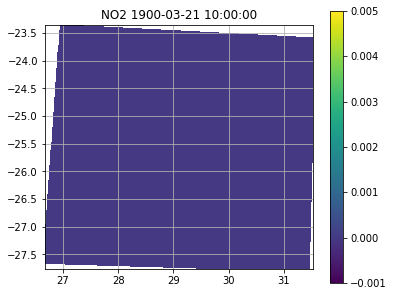

In [45]:
# Plot upscaled NO2
fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=upscaled_no2_img, 
                 feature=(FeatureType.DATA, 'NO2'),
                 time_idx=5, 
                 vmin=-0.001, vmax=0.005)
fig.colorbar(fh, ax=ax);